#  Motivação

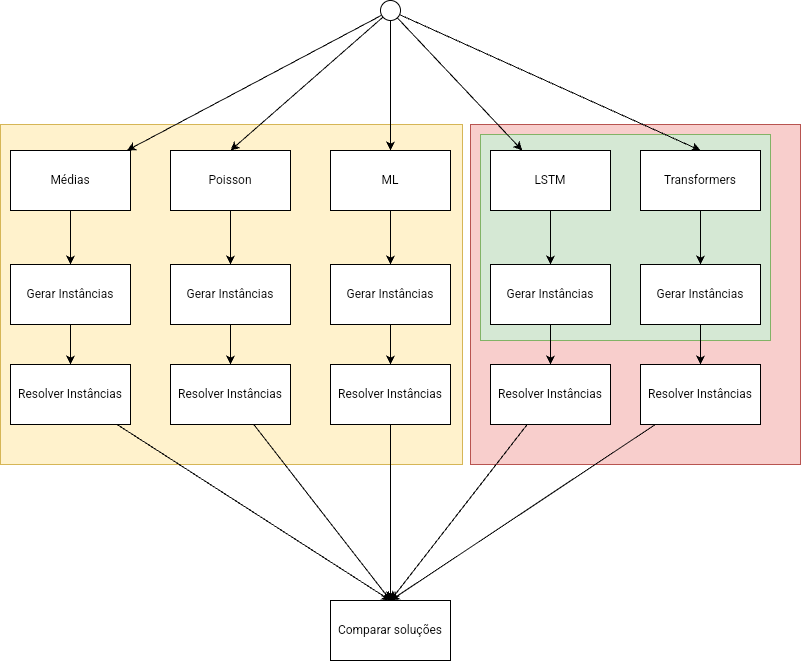

## 0. Imports and configs


In [ ]:
import pickle
from datetime import datetime
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.layers import Layer, Input, Dense, LSTM, LayerNormalization, Dropout, MultiHeadAttention, Add
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.utils import register_keras_serializable



In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
TEST_SIZE = 0.20
SEED = 42

## 1. Loading and split data

### 1.1 Loading data

In [ ]:
ROOT_PATH = "/content/drive/MyDrive/Bike4Real/data/"
# ROOT_PATH = "/kaggle/input/"
X_path = ROOT_PATH + "X_cp.pkl"
y_path = ROOT_PATH + "y_cp.pkl"

In [ ]:
try:
  with open(X_path, 'rb') as file:
    X = pickle.load(file)
  print("X loaded successfully!")

  with open(y_path, 'rb') as file:
    y = pickle.load(file)
  print("y loaded successfully!")

except FileNotFoundError:
  print(f"Error: One or both of the files were not found. \nCheck the file paths: {X_path}, {y_path}")
except Exception as e:
  print(f"An error occurred: {e}")


X loaded successfully!
y loaded successfully!


In [ ]:
X.shape, y.shape

((1390777, 10, 12), (1390777, 1, 12))

In [ ]:
X[1, :, :]

array([[0.000e+00, 0.000e+00, 2.024e+03, 4.000e+00, 1.800e+01, 2.000e+00,
        5.800e+01, 2.024e+03, 4.000e+00, 1.800e+01, 2.000e+00, 5.800e+01],
       [0.000e+00, 0.000e+00, 2.024e+03, 4.000e+00, 1.800e+01, 3.000e+00,
        3.000e+00, 2.024e+03, 4.000e+00, 1.800e+01, 3.000e+00, 4.000e+00],
       [0.000e+00, 0.000e+00, 2.024e+03, 4.000e+00, 1.800e+01, 3.000e+00,
        4.000e+00, 2.024e+03, 4.000e+00, 1.800e+01, 3.000e+00, 5.000e+00],
       [0.000e+00, 0.000e+00, 2.024e+03, 4.000e+00, 1.800e+01, 3.000e+00,
        6.000e+00, 2.024e+03, 4.000e+00, 1.800e+01, 3.000e+00, 6.000e+00],
       [0.000e+00, 0.000e+00, 2.024e+03, 4.000e+00, 1.800e+01, 3.000e+00,
        6.000e+00, 2.024e+03, 4.000e+00, 1.800e+01, 3.000e+00, 6.000e+00],
       [0.000e+00, 0.000e+00, 2.024e+03, 4.000e+00, 1.800e+01, 3.000e+00,
        6.000e+00, 2.024e+03, 4.000e+00, 1.800e+01, 3.000e+00, 7.000e+00],
       [0.000e+00, 0.000e+00, 2.024e+03, 4.000e+00, 1.800e+01, 3.000e+00,
        7.000e+00, 2.024e+03, 4.

### 1.2 Split Data

In [ ]:
x_shape = X.shape
y_shape = y.shape

# Criando os escaladores
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

# Reshape necessário para manter a compatibilidade
X = X.reshape(-1, X.shape[-1])  # Transforma para (total_samples * timesteps, features)
y = y.reshape(-1, y.shape[-1])  # Transforma para (total_samples * timesteps, features)

# Aplicando a normalização
X = scaler_x.fit_transform(X).reshape(x_shape)
y = scaler_y.fit_transform(y).reshape(y_shape)


In [ ]:
X.shape

(1390777, 10, 12)

In [ ]:
y[1, :, :]

array([[0.        , 0.        , 0.        , 0.6       , 0.6       ,
        0.13043478, 0.59322034, 0.        , 0.6       , 0.6       ,
        0.13043478, 0.6440678 ]])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=SEED)

## 2. LSTM

In [ ]:
model_lstm = Sequential([
    LSTM(256, return_sequences=True, input_shape=(10, 12)),
    LSTM(128, return_sequences=True),
    LSTM(128, return_sequences=False),

    # Camada totalmente conectada
    Dense(128, activation="relu"),
    Dense(64, activation="relu"),
    Dense(32, activation="relu"),
    Dense(12, activation='relu')
])

In [ ]:
# Compilação
model_lstm.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse', metrics=["mae", "mse"])

In [ ]:
model_lstm.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                        │ (None, 10, 256)             │         275,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 10, 128)             │         197,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 12)                  │             396 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 631,404 (2.41 MB)

 Trainable params: 631,404 (2.41 MB)

 Non-trainable params: 0 (0.00 B)

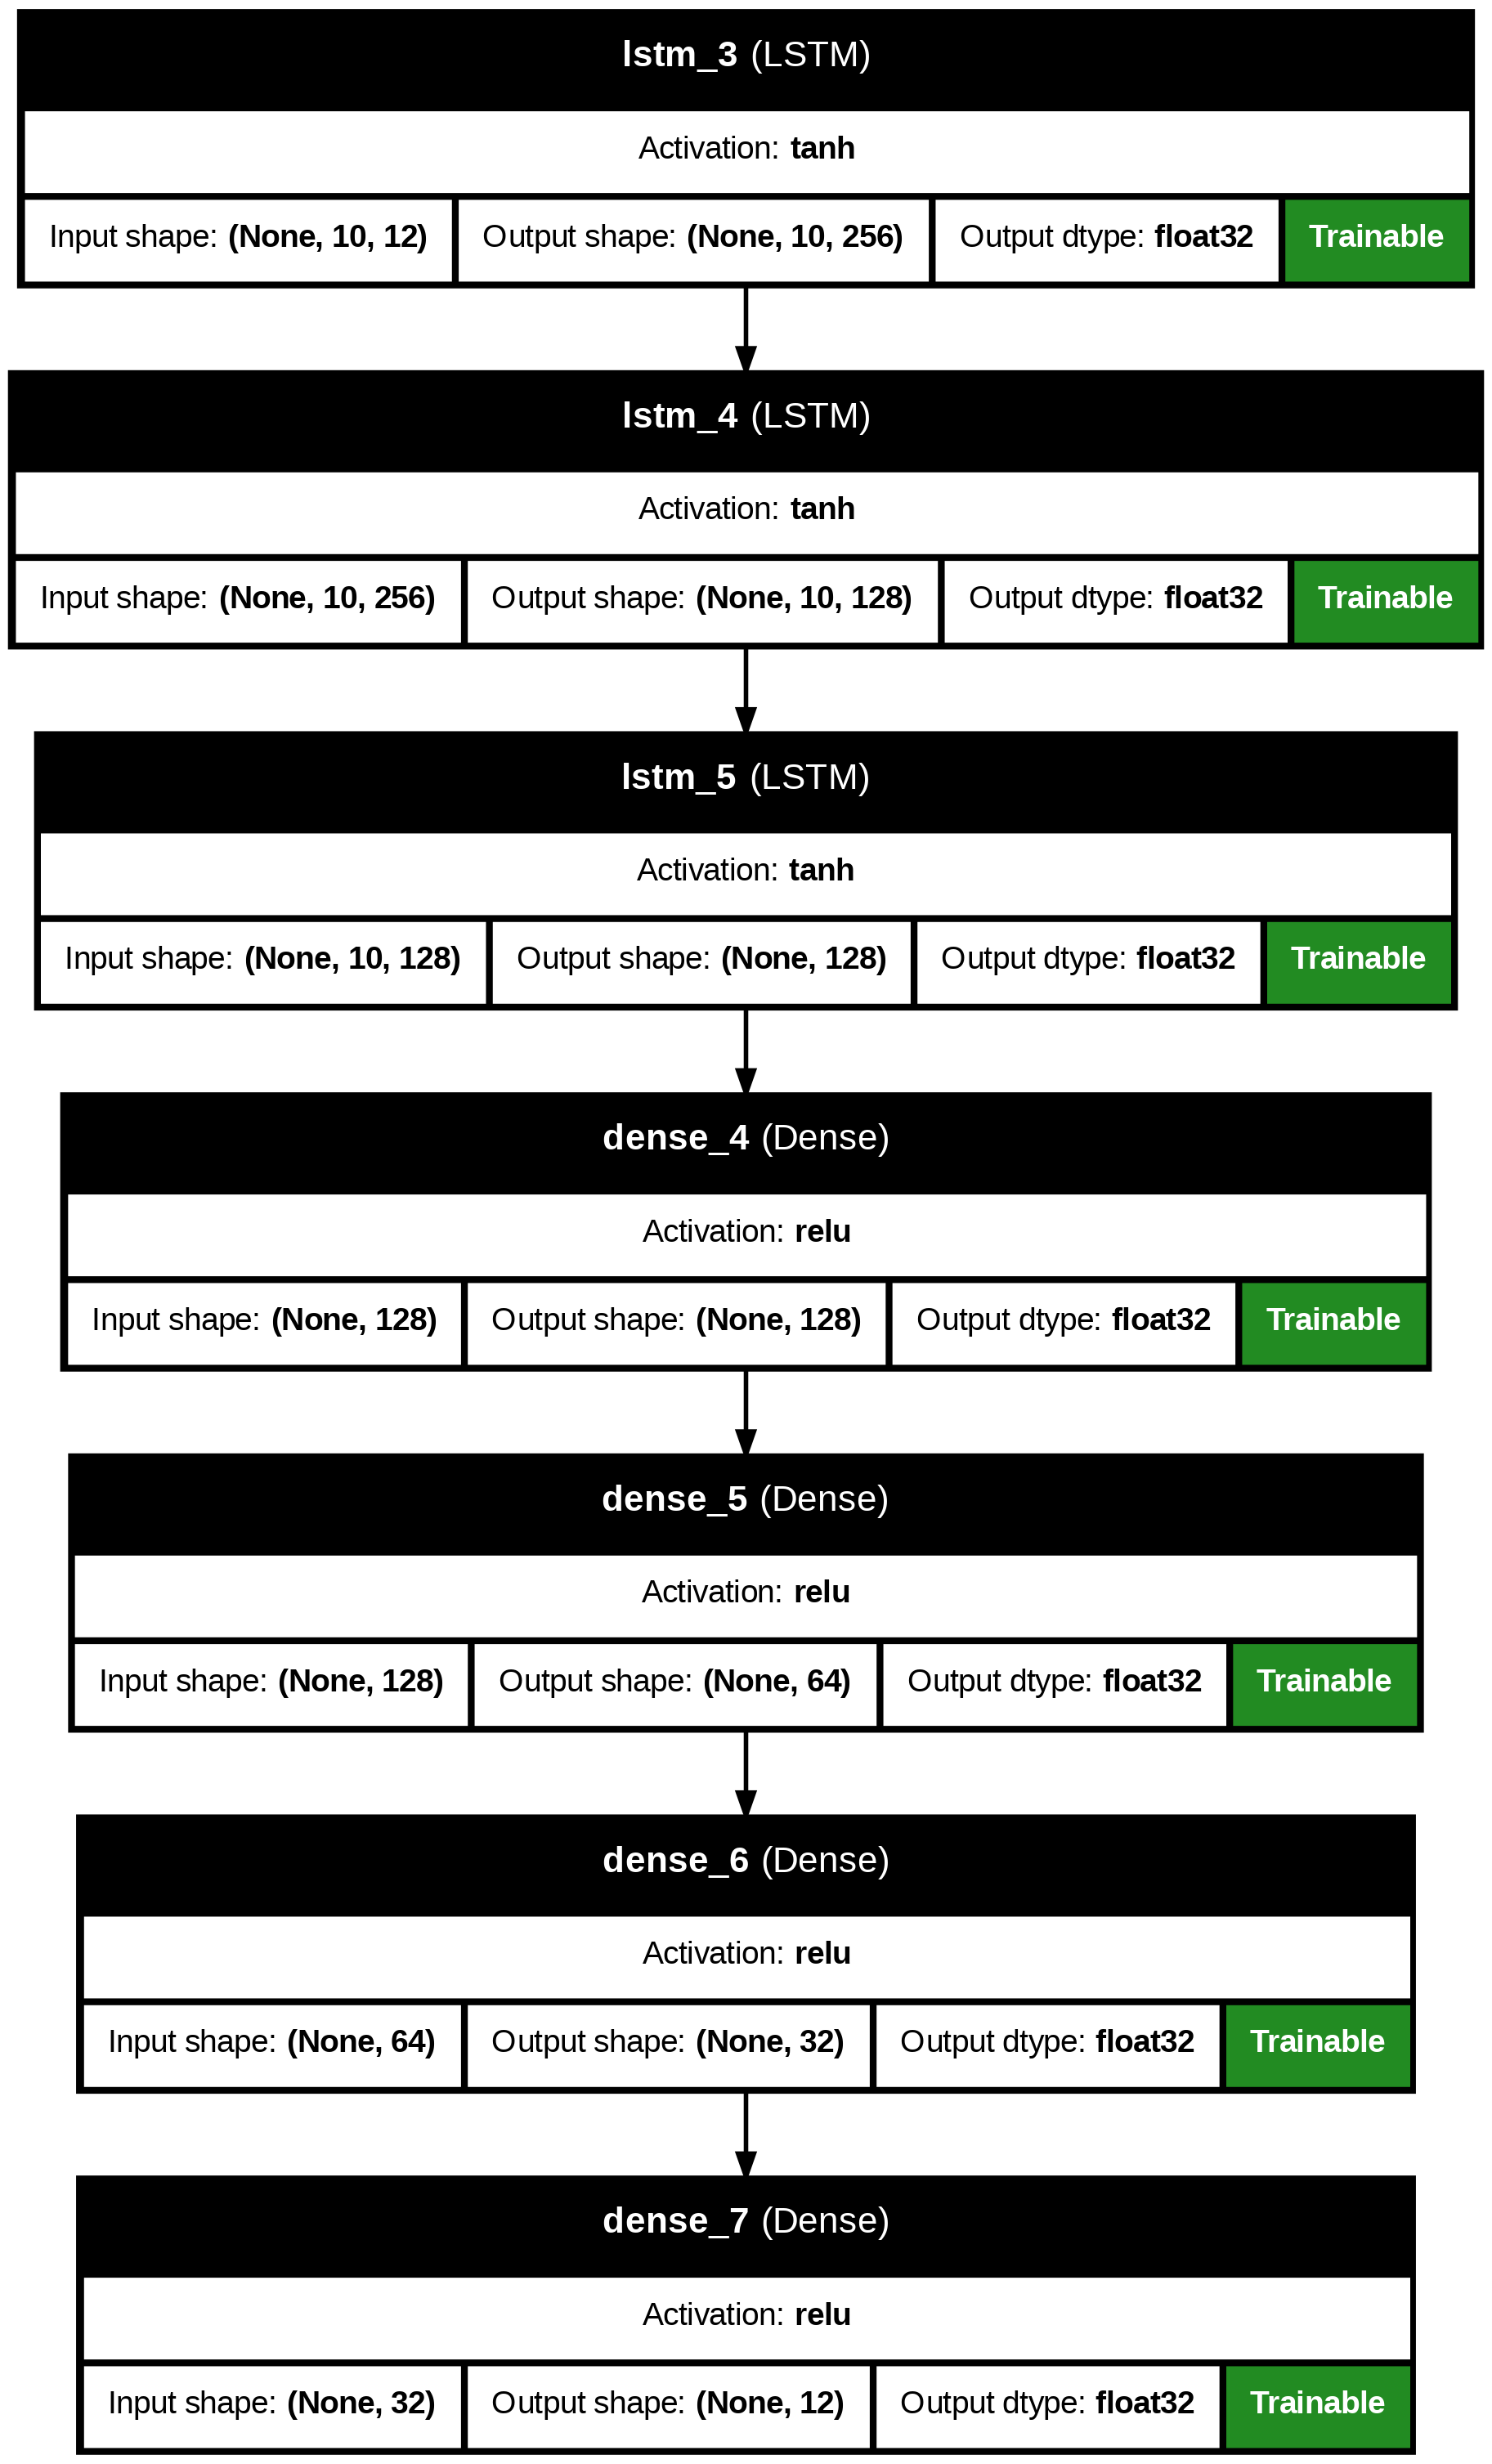

In [ ]:
tf.keras.utils.plot_model(
    model_lstm,
    to_file='model_lstm.png',
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=True,
    dpi=200,
    show_layer_activations=True,
    show_trainable=True,
)

### 2.1 Train

In [ ]:
history_lstm = model_lstm.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=4092,
    shuffle=True,
    verbose=1
)


Epoch 1/10
272/272 ━━━━━━━━━━━━━━━━━━━━ 40s 136ms/step - loss: 0.0924 - mae: 0.2153 - mse: 0.0924 - val_loss: 0.0570 - val_mae: 0.1759 - val_mse: 0.0570
Epoch 2/10
272/272 ━━━━━━━━━━━━━━━━━━━━ 36s 133ms/step - loss: 0.0572 - mae: 0.1764 - mse: 0.0572 - val_loss: 0.0575 - val_mae: 0.1796 - val_mse: 0.0575
Epoch 3/10
272/272 ━━━━━━━━━━━━━━━━━━━━ 36s 133ms/step - loss: 0.0572 - mae: 0.1765 - mse: 0.0572 - val_loss: 0.0571 - val_mae: 0.1750 - val_mse: 0.0571
Epoch 4/10
272/272 ━━━━━━━━━━━━━━━━━━━━ 36s 133ms/step - loss: 0.0572 - mae: 0.1764 - mse: 0.0572 - val_loss: 0.0571 - val_mae: 0.1773 - val_mse: 0.0571
Epoch 5/10
272/272 ━━━━━━━━━━━━━━━━━━━━ 36s 133ms/step - loss: 0.0571 - mae: 0.1764 - mse: 0.0571 - val_loss: 0.0571 - val_mae: 0.1747 - val_mse: 0.0571
Epoch 6/10
272/272 ━━━━━━━━━━━━━━━━━━━━ 36s 133ms/step - loss: 0.0571 - mae: 0.1764 - mse: 0.0571 - val_loss: 0.0572 - val_mae: 0.1741 - val_mse: 0.0572
Epoch 7/10
272/272 ━━━━━━━━━━━━━━━━━━━━ 36s 133ms/step - loss: 0.0571 - mae: 0.176

### 2.2. Metrics

#### 2.2.1 Loss

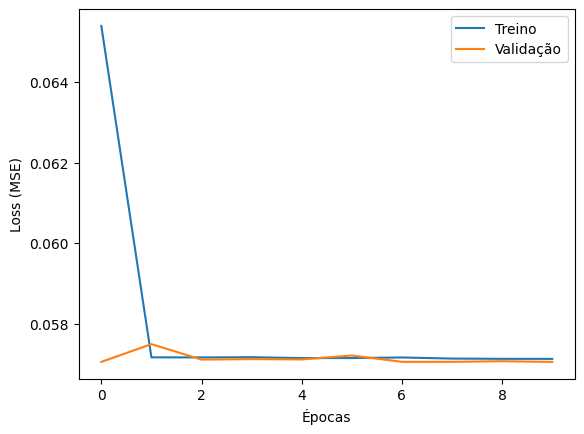

In [ ]:
plt.plot(history_lstm.history["loss"], label="Treino")
plt.plot(history_lstm.history["val_loss"], label="Validação")
plt.xlabel("Épocas")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.show()

#### 2.2.2 MAE

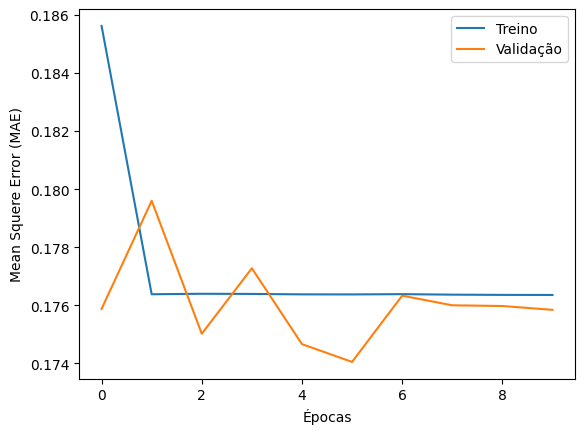

In [ ]:
plt.plot(history_lstm.history["mae"], label="Treino")
plt.plot(history_lstm.history["val_mae"], label="Validação")
plt.xlabel("Épocas")
plt.ylabel("Mean Squere Error (MAE)")
plt.legend()
plt.show()

#### 2.2.3 RMSE

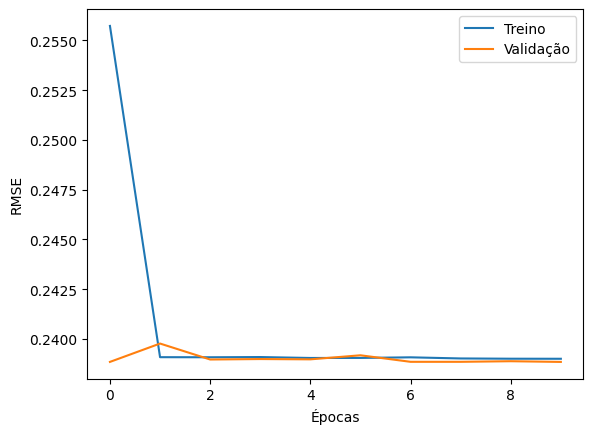

In [ ]:
# Calcula RMSE para treino e validação
rmse_train = np.sqrt(history_lstm.history['mse'])
rmse_val = np.sqrt(history_lstm.history['val_mse'])

# Plot
plt.plot(rmse_train, label="Treino")
plt.plot(rmse_val, label="Validação")
plt.xlabel("Épocas")
plt.ylabel("RMSE")
plt.legend()
plt.show()

### Saving LSTM model

In [ ]:
model_lstm.save("lstm_bike_travel.keras")

### Loading LSTM model

In [ ]:
lstm_loaded = load_model("/content/drive/MyDrive/Bike4Real/models/lstm_bike_travel.keras")

### Predict with reload model

In [ ]:
def predict_next_trip_with_input(model,
                                 last_data,
                                 input_size=5,
                                 label_size=1,
                                 scaler_x=None,
                                 scaler_y=None,
                                 is_transformer=False):
    """
    Recebe os últimos dados e prevê a próxima(s) viagem(ns), retornando o input junto com a saída prevista.

    Parameters:
        model (tf.keras.Model): O modelo treinado para prever a próxima viagem.
        last_data (np.ndarray): Dados das últimas viagens, com shape (input_size, 4).
        input_size (int): Número de viagens consecutivas para o input.
        label_size (int): Número de viagens para o label (próxima(s) viagem(ns)).
        scaler_x (MinMaxScaler ou None): O escalador usado para os dados de entrada (X).
        scaler_y (MinMaxScaler ou None): O escalador usado para os dados de saída (y).

    Returns:
        input_data (np.ndarray): Os dados de entrada usados para a previsão.
        next_trip (np.ndarray): A previsão da próxima viagem.
    """

    # Verifica se os dados de entrada têm o tamanho adequado
    if last_data.shape[0] != input_size:
        raise ValueError(f"Os dados de entrada devem ter exatamente {input_size} viagens.")

    # Se for necessário, normaliza os dados de entrada
    if scaler_x is not None:
        last_data_normalized = scaler_x.transform(last_data.reshape(-1, last_data.shape[-1])).reshape(last_data.shape)
    else:
        last_data_normalized = last_data

    if not is_transformer:
        # Faz a previsão para o próximo conjunto de dados
        next_trip_normalized = model.predict(last_data_normalized[np.newaxis, :, :])  # Adiciona uma dimensão para batch
    else:
        next_trip_normalized = model.predict([last_data_normalized[np.newaxis, :, :], last_data_normalized[np.newaxis, -1:, :]])  # Adiciona uma dimensão para batch

    # Desnormaliza o resultado, se o scaler_y for fornecido
    if scaler_y is not None:
        next_trip = scaler_y.inverse_transform(next_trip_normalized.reshape(-1, next_trip_normalized.shape[-1])).reshape(next_trip_normalized.shape)
    else:
        next_trip = next_trip_normalized

    # Retorna os dados de entrada e a previsão
    return last_data, next_trip


In [ ]:
next_trip = predict_next_trip_with_input(lstm_loaded, X_test[3, :, :], input_size=10, label_size=1, scaler_y=scaler_y)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


In [ ]:
travel_history = scaler_y.inverse_transform(X_test[3, :, :].reshape(-1, X_test[3, :, :].shape[-1])).reshape(X_test[3, :, :].shape)

In [ ]:
travel_history

array([[ 704.,  496., 2024.,    5.,    6.,   23.,   14., 2024.,    5.,
           6.,   23.,   18.],
       [ 704.,  496., 2024.,    5.,    7.,    3.,   24., 2024.,    5.,
           7.,    3.,   27.],
       [ 704.,  496., 2024.,    5.,    7.,   21.,   37., 2024.,    5.,
           7.,   21.,   41.],
       [ 704.,  496., 2024.,    5.,    8.,   22.,   59., 2024.,    5.,
           8.,   23.,    3.],
       [ 704.,  496., 2024.,    5.,    9.,   15.,   57., 2024.,    5.,
           9.,   16.,   26.],
       [ 704.,  496., 2024.,    5.,    9.,   15.,   57., 2024.,    5.,
           9.,   16.,   26.],
       [ 704.,  496., 2024.,    5.,    9.,   23.,    9., 2024.,    5.,
           9.,   23.,   12.],
       [ 704.,  496., 2024.,    5.,   10.,   19.,    5., 2024.,    5.,
          10.,   19.,   11.],
       [ 704.,  496., 2024.,    5.,   11.,   18.,   34., 2024.,    5.,
          11.,   18.,   39.],
       [ 704.,  496., 2024.,    5.,   12.,   19.,    9., 2024.,    5.,
          12.,   19.

In [ ]:
next_travel = scaler_y.inverse_transform(y_test[3, :, :].reshape(-1, y_test[3, :, :].shape[-1])).reshape(y_test[3, :, :].shape)
next_travel

array([[ 704.,  496., 2024.,    5.,   12.,   21.,    4., 2024.,    5.,
          12.,   21.,    8.]])

In [ ]:
predicted_next_travel = np.round(next_trip[1])
predicted_next_travel

array([[ 265.,  273., 2024.,    5.,   18.,   15.,   30., 2024.,    5.,
          18.,   15.,   30.]], dtype=float32)

In [ ]:
np.round(np.squeeze(next_travel)),  np.round(np.squeeze(predicted_next_travel))

(array([ 704.,  496., 2024.,    5.,   12.,   21.,    4., 2024.,    5.,
          12.,   21.,    8.]),
 array([ 265.,  273., 2024.,    5.,   18.,   15.,   30., 2024.,    5.,
          18.,   15.,   30.], dtype=float32))

## 3. Transformer

#### Hiperparâmetros

In [ ]:
# Entrada
num_features = 12 # Número de campos presentes na sequência de entrada
seq_len_enc = 10  # Quantidade de sequências de entrada

# Saída
output_dim = 12   # Quantidade de campos presentes na sequencia de saida passo de saida
seq_len_dec = 1   # Quantidade da sequência de saída

# Camadas, feed forward, etc.
num_heads = 4
ff_dim = 64
dropout_rate = 0.1
num_layers = 2

#### Positional Encoding

In [ ]:
class PositionalEncoding(Layer):
    def __init__(self, sequence_len, d_model, **kwargs):
        super().__init__(**kwargs)
        self.sequence_len = sequence_len
        self.d_model = d_model

    def get_angles(self, pos, i):
        angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(self.d_model))
        return pos * angle_rates

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        pos = np.arange(self.sequence_len)[:, np.newaxis]
        i = np.arange(self.d_model)[np.newaxis, :]
        angle_rads = self.get_angles(pos, i)

        # Aplica seno aos índices pares; cosseno aos ímpares
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

        pos_encoding = angle_rads[np.newaxis, ...]  # shape: (1, seq_len, d_model)
        return inputs + tf.cast(pos_encoding, dtype=tf.float32)

# Register the layers manually
tf.keras.utils.get_custom_objects().update({
    "PositionalEncoding": PositionalEncoding,
})

#### Encoder Layer

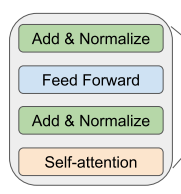

In [ ]:
@register_keras_serializable()
class TransformerEncoder(tf.keras.layers.Layer):
    def __init__(self, num_heads, ff_dim, dropout_rate=0.1, **kwargs):
        super().__init__(**kwargs)
        self.attention = MultiHeadAttention(num_heads=num_heads, key_dim=ff_dim)
        self.norm1 = LayerNormalization()
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation='relu'),
            Dense(ff_dim),
        ])
        self.norm2 = LayerNormalization()
        self.dropout = Dropout(dropout_rate)
        self.projection = Dense(ff_dim)

    def call(self, inputs, training=False):
        # Project input shape to ff_dim shape
        proj_inputs = self.projection(inputs)

        # attention
        attn_output = self.attention(proj_inputs, proj_inputs)

        # Add + Normalize
        out1 = self.norm1(proj_inputs + attn_output)

        # Feed Forward
        ffn_output = self.ffn(out1)

        # Dropout (não presente na arquitetura proposta pelo artigo)
        ffn_output = self.dropout(ffn_output, training=training)

        # Add + Normalize
        return self.norm2(out1 + ffn_output)

# Register the layers manually
tf.keras.utils.get_custom_objects().update({
    "TransformerEncoder": TransformerEncoder,
})

#### Decoder Layer

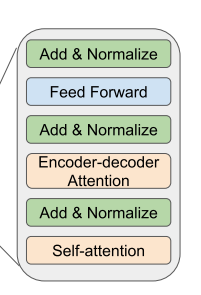

In [ ]:
@register_keras_serializable()
class TransformerDecoder(tf.keras.layers.Layer):
    def __init__(self, num_heads, ff_dim, dropout_rate=0.1, **kwargs):
        super().__init__(**kwargs)
        self.projection = Dense(ff_dim)
        self.self_attention = MultiHeadAttention(num_heads=num_heads, key_dim=ff_dim)
        self.norm1 = LayerNormalization()
        self.enc_dec_attention = MultiHeadAttention(num_heads=num_heads, key_dim=ff_dim)
        self.norm2 = LayerNormalization()
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation='relu'),
            Dense(ff_dim),
        ])
        self.norm3 = LayerNormalization()
        self.dropout = Dropout(dropout_rate)

    def call(self, decoder_input, encoder_output, training=False):
        # Projeção da entrada para o shape ff_dim
        proj_input = self.projection(decoder_input)

        # Self-Attention
        attn1 = self.self_attention(proj_input, proj_input)

        # Add + Normalize
        out1 = self.norm1(proj_input + attn1)

        # Self-Attention
        attn2 = self.enc_dec_attention(out1, encoder_output)

        # Add + Normalize
        out2 = self.norm2(out1 + attn2)

        # Feed Forward
        ffn_output = self.ffn(out2)

        # dropout
        ffn_output = self.dropout(ffn_output, training=training)

        # Add + Normalize
        return self.norm3(out2 + ffn_output)


# Register the layers manually
tf.keras.utils.get_custom_objects().update({
    "TransformerDecoder": TransformerDecoder,
})

#### Complete model (Encoder-Decoder)

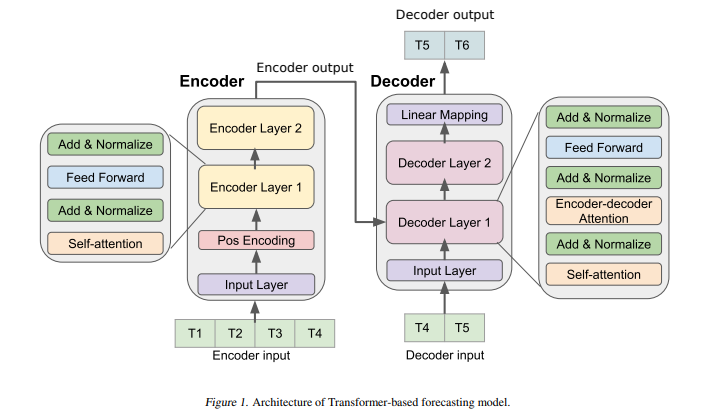

> WU, Neo et al. Deep transformer models for time series forecasting: The influenza prevalence case. arXiv preprint arXiv:2001.08317, 2020.

📘[Deep Transformer Models for Time Series Forecasting: The Influenza Prevalence Case](https://arxiv.org/abs/2001.08317)

In [ ]:
encoder_inputs = Input(shape=(seq_len_enc, num_features), name="Encoder_Input")
decoder_inputs = Input(shape=(seq_len_dec, num_features), name="Decoder_Input")

x_enc = encoder_inputs
x_enc = Dense(ff_dim, name="Encoder_Input_Projection")(x_enc)  # Projeção
x_enc = PositionalEncoding(seq_len_enc, ff_dim, name="Positional_Encoding")(x_enc)

for i in range(num_layers):
    x_enc = TransformerEncoder(num_heads, ff_dim, dropout_rate,  name=f"Encoder_Layer_{i+1}")(x_enc)


x_dec = decoder_inputs
x_dec = Dense(ff_dim, name="Decoder_Input_Projection")(x_dec)  # Projeção
# x_dec = PositionalEncoding(seq_len_dec, ff_dim)(x_dec)

for i in range(num_layers):
    x_dec = TransformerDecoder(num_heads, ff_dim, dropout_rate, name=f"Decoder_Layer_{i+1}")(x_dec, x_enc)


# Saída para regressão multivariada
outputs = Dense(output_dim, name="Out")(x_dec)

model_transformer = Model([encoder_inputs, decoder_inputs], outputs, name='tranformers_bike')

In [ ]:
# Compilação do modelo
model_transformer.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss="mse", metrics=["mae", "mse"])

In [ ]:
model_transformer.summary()

Model: "tranformers_bike"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Encoder_Input             │ (None, 10, 12)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Encoder_Input_Projection  │ (None, 10, 64)         │            832 │ Encoder_Input[0][0]    │
│ (Dense)                   │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Positional_Encoding       │ (None, 10, 64)         │              0 │ Encoder_Input_Project… │
│ (PositionalEncoding)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Decoder_Input             │ (None, 1, 12)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Encoder_Layer_1           │ (None, 10, 64)         │         79,104 │ Positional_Encoding[0… │
│ (TransformerEncoder)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Decoder_Input_Projection  │ (None, 1, 64)          │            832 │ Decoder_Input[0][0]    │
│ (Dense)                   │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Encoder_Layer_2           │ (None, 10, 64)         │         79,104 │ Encoder_Layer_1[0][0]  │
│ (TransformerEncoder)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Decoder_Layer_1           │ (None, 1, 64)          │        145,600 │ Decoder_Input_Project… │
│ (TransformerDecoder)      │                        │                │ Encoder_Layer_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Decoder_Layer_2           │ (None, 1, 64)          │        145,600 │ Decoder_Layer_1[0][0], │
│ (TransformerDecoder)      │                        │                │ Encoder_Layer_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Out (Dense)               │ (None, 1, 12)          │            780 │ Decoder_Layer_2[0][0]  │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 451,852 (1.72 MB)

 Trainable params: 451,852 (1.72 MB)

 Non-trainable params: 0 (0.00 B)

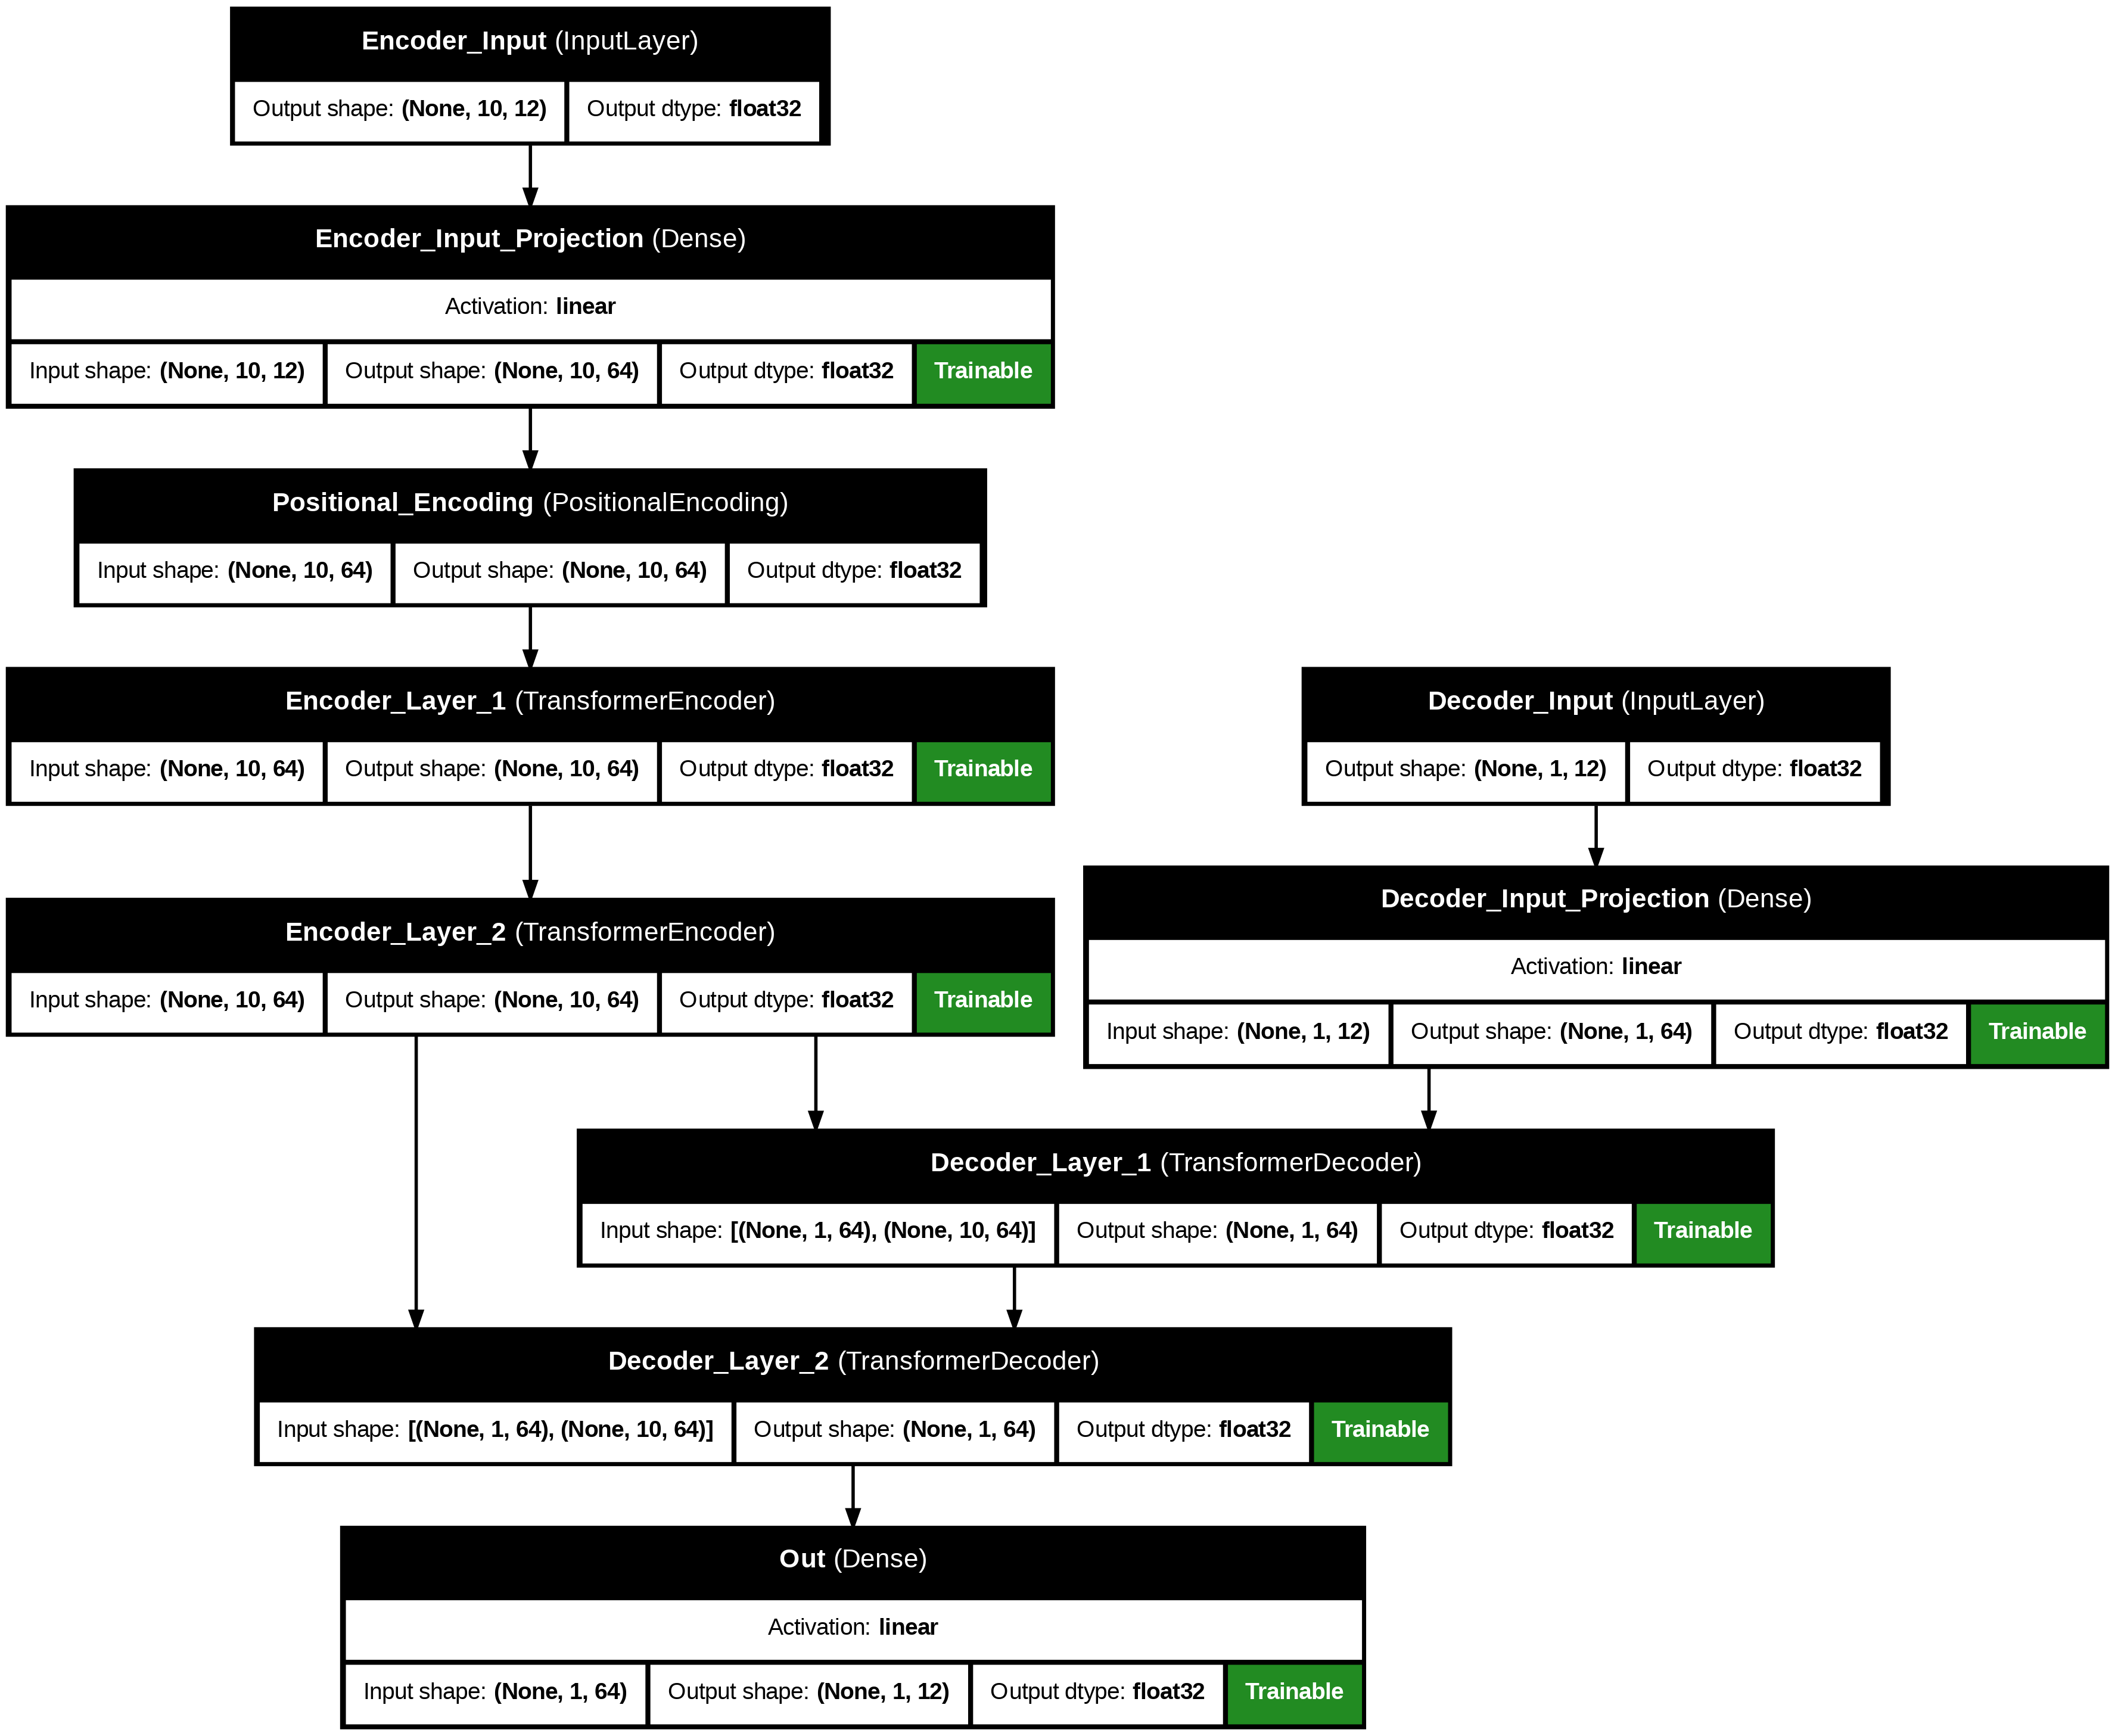

In [ ]:
tf.keras.utils.plot_model(
    model_transformer,
    to_file='model_transformer.png',
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=200,
    show_layer_activations=True,
    show_trainable=True,
)

### 3.1 Train and test

In [ ]:
def build_transformer_inputs(data):
    X_encoder = data[:, :10, :]  # Os 10 timesteps como entrada
    X_decoder = data[:, -1:, :]  # Último timestep (10º) como entrada do decoder
    return X_encoder, X_decoder

# Exemplo:
# data = np.random.rand(1000, 10, 12)  # 1000 amostras, 10 timesteps, 12 features
X_encoder_train, X_decoder_train = build_transformer_inputs(X_train)
X_encoder_test, X_decoder_test = build_transformer_inputs(X_test)

In [ ]:
history_transformer = model_transformer.fit(
    [X_encoder_train, X_decoder_train], y_train,
    validation_data=([X_encoder_test, X_decoder_test], y_test),
    epochs=10,
    batch_size=2046*2,
    shuffle=True,
    verbose=1
)

Epoch 1/10
272/272 ━━━━━━━━━━━━━━━━━━━━ 51s 101ms/step - loss: 0.1606 - mae: 0.2484 - mse: 0.1606 - val_loss: 0.0343 - val_mae: 0.1092 - val_mse: 0.0343
Epoch 2/10
272/272 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - loss: 0.0346 - mae: 0.1114 - mse: 0.0346 - val_loss: 0.0337 - val_mae: 0.1047 - val_mse: 0.0337
Epoch 3/10
272/272 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - loss: 0.0340 - mae: 0.1069 - mse: 0.0340 - val_loss: 0.0335 - val_mae: 0.1030 - val_mse: 0.0335
Epoch 4/10
272/272 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - loss: 0.0336 - mae: 0.1054 - mse: 0.0336 - val_loss: 0.0330 - val_mae: 0.1018 - val_mse: 0.0330
Epoch 5/10
272/272 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - loss: 0.0331 - mae: 0.1032 - mse: 0.0331 - val_loss: 0.0332 - val_mae: 0.1057 - val_mse: 0.0332
Epoch 6/10
272/272 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - loss: 0.0328 - mae: 0.1018 - mse: 0.0328 - val_loss: 0.0325 - val_mae: 0.0987 - val_mse: 0.0325
Epoch 7/10
272/272 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - loss: 0.0327 - mae: 0.1010 - ms

### 3.2 Metrics

#### 3.2.1 Loss

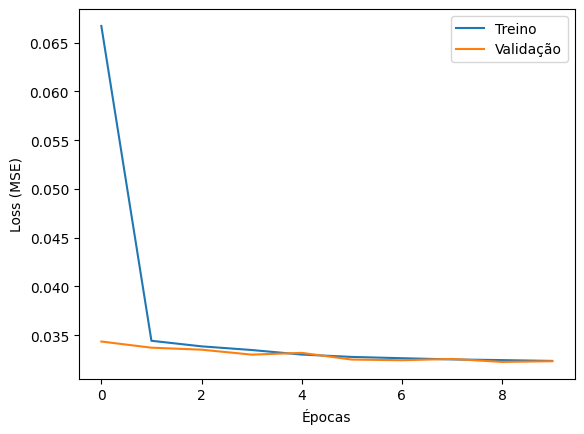

In [ ]:
plt.plot(history_transformer.history["loss"], label="Treino")
plt.plot(history_transformer.history["val_loss"], label="Validação")
plt.xlabel("Épocas")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.show()

#### 3.2.2 MAE

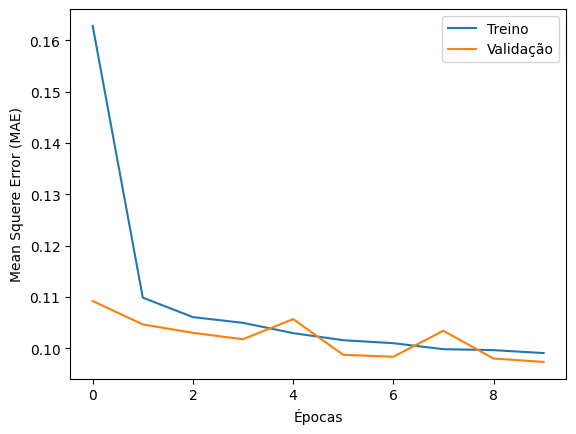

In [ ]:
plt.plot(history_transformer.history["mae"], label="Treino")
plt.plot(history_transformer.history["val_mae"], label="Validação")
plt.xlabel("Épocas")
plt.ylabel("Mean Squere Error (MAE)")
plt.legend()
plt.show()

#### 3.2.3 RMSE

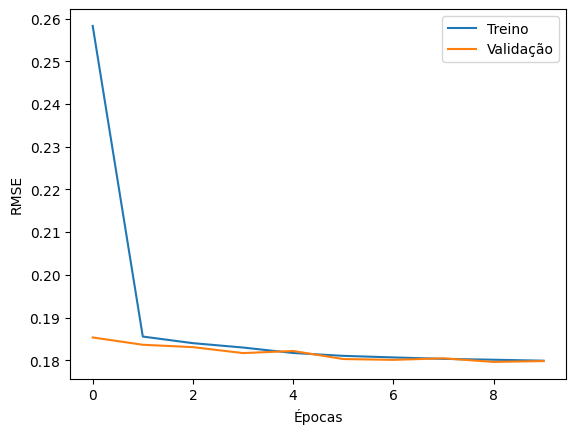

In [ ]:
# Calcula RMSE para treino e validação
rmse_train = np.sqrt(history_transformer.history['mse'])
rmse_val = np.sqrt(history_transformer.history['val_mse'])

# Plot
plt.plot(rmse_train, label="Treino")
plt.plot(rmse_val, label="Validação")
plt.xlabel("Épocas")
plt.ylabel("RMSE")
plt.legend()
plt.show()

### Saving Transformer

In [ ]:
model_transformer.save("transformer_bike_travel.keras")

### Loading Transformer

In [ ]:
transformer_loaded = load_model("/content/drive/MyDrive/Bike4Real/models/transformer_bike_travel.keras")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'Encoder_Layer_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'Encoder_Layer_2', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'Decoder_Layer_1', however the lay

### 3.3 Predict

In [ ]:
next_trip = predict_next_trip_with_input(transformer_loaded, X_test[0, :, :], input_size=10, label_size=1, scaler_y=scaler_y, is_transformer=True)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


In [ ]:
travel_history = scaler_y.inverse_transform(X_test[3, :, :].reshape(-1, X_test[0, :, :].shape[-1])).reshape(X_test[0, :, :].shape)

In [ ]:
travel_history

array([[ 704.,  496., 2024.,    5.,    6.,   23.,   14., 2024.,    5.,
           6.,   23.,   18.],
       [ 704.,  496., 2024.,    5.,    7.,    3.,   24., 2024.,    5.,
           7.,    3.,   27.],
       [ 704.,  496., 2024.,    5.,    7.,   21.,   37., 2024.,    5.,
           7.,   21.,   41.],
       [ 704.,  496., 2024.,    5.,    8.,   22.,   59., 2024.,    5.,
           8.,   23.,    3.],
       [ 704.,  496., 2024.,    5.,    9.,   15.,   57., 2024.,    5.,
           9.,   16.,   26.],
       [ 704.,  496., 2024.,    5.,    9.,   15.,   57., 2024.,    5.,
           9.,   16.,   26.],
       [ 704.,  496., 2024.,    5.,    9.,   23.,    9., 2024.,    5.,
           9.,   23.,   12.],
       [ 704.,  496., 2024.,    5.,   10.,   19.,    5., 2024.,    5.,
          10.,   19.,   11.],
       [ 704.,  496., 2024.,    5.,   11.,   18.,   34., 2024.,    5.,
          11.,   18.,   39.],
       [ 704.,  496., 2024.,    5.,   12.,   19.,    9., 2024.,    5.,
          12.,   19.

In [ ]:
next_travel = scaler_y.inverse_transform(y_test[3, :, :].reshape(-1, y_test[0, :, :].shape[-1])).reshape(y_test[0, :, :].shape)
next_travel

array([[ 704.,  496., 2024.,    5.,   12.,   21.,    4., 2024.,    5.,
          12.,   21.,    8.]])

In [ ]:
predicted_next_travel = np.round(next_trip[1])
predicted_next_travel

array([[[  99.,  100., 2024.,    5.,   15.,   16.,   27., 2024.,    5.,
           15.,   16.,   28.]]], dtype=float32)

In [ ]:
np.round(np.squeeze(next_travel)),  np.round(np.squeeze(predicted_next_travel))

(array([ 704.,  496., 2024.,    5.,   12.,   21.,    4., 2024.,    5.,
          12.,   21.,    8.]),
 array([  99.,  100., 2024.,    5.,   15.,   16.,   27., 2024.,    5.,
          15.,   16.,   28.], dtype=float32))

## General prediction with models

In [ ]:
def general_prediction(model, X, y, scaler_y, is_transformer=False):
    random_index =  np.random.randint(0, X.shape[0])

    predicted_next_travel = predict_next_trip_with_input(model,
                                             X[random_index, :, :],
                                             input_size=10,
                                             label_size=1,
                                             scaler_y=scaler_y,
                                             is_transformer=is_transformer)





    travel_history = scaler_y.inverse_transform(X[3, :, :].reshape(-1, X[random_index, :, :].shape[-1])).reshape(X[random_index, :, :].shape)

    next_travel_real = scaler_y.inverse_transform(y[3, :, :].reshape(-1, y[random_index, :, :].shape[-1])).reshape(y[random_index, :, :].shape)
    next_travel_real = np.round(np.squeeze(next_travel_real)).astype(np.int16)

    predicted_next_travel = np.round(predicted_next_travel[1])
    predicted_next_travel = np.round(np.squeeze(predicted_next_travel)).astype(np.int16)


    est_origem_real = next_travel_real[0]
    est_destino_real = next_travel_real[1]
    saida_real = datetime(next_travel_real[2], next_travel_real[3], next_travel_real[4], next_travel_real[5], next_travel_real[6])
    chegada_real = datetime(next_travel_real[7], next_travel_real[8], next_travel_real[9], next_travel_real[10], next_travel_real[11])


    est_origem_predict = predicted_next_travel[0]
    est_destino_predict = predicted_next_travel[1]
    saida_predict = datetime(predicted_next_travel[2], predicted_next_travel[3], predicted_next_travel[4], predicted_next_travel[5], predicted_next_travel[6])
    chegada_predict = datetime(predicted_next_travel[7], predicted_next_travel[8], predicted_next_travel[9], predicted_next_travel[10], predicted_next_travel[11])


    print("Viagem real")
    print(f"🚉 Estação de origem (real): {est_origem_real}")
    print(f"🏁 Estação de destino (real): {est_destino_real}")
    print(f"🕒 Saída (real): {saida_real.strftime('%d/%m/%Y %H:%M')}")
    print(f"🕓 Chegada (real): {chegada_real.strftime('%d/%m/%Y %H:%M')}")

    print("")

    print("Viagem predita")
    print(f"🚉 Estação de origem: {est_origem_predict}")
    print(f"🏁 Estação de destino: {est_destino_predict}")
    print(f"🕒 Saída: {saida_predict.strftime('%d/%m/%Y %H:%M')}")
    print(f"🕓 Chegada: {chegada_predict.strftime('%d/%m/%Y %H:%M')}")


### LSTM

In [ ]:
for i in range(10):
    general_prediction(model=lstm_loaded, X=X_test, y=y_test, scaler_y=scaler_y, is_transformer=False)
    print(50*"=")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 526ms/step
Viagem real
🚉 Estação de origem (real): 704
🏁 Estação de destino (real): 496
🕒 Saída (real): 12/05/2024 21:04
🕓 Chegada (real): 12/05/2024 21:08

Viagem predita
🚉 Estação de origem: 265
🏁 Estação de destino: 272
🕒 Saída: 18/05/2024 15:30
🕓 Chegada: 18/05/2024 15:30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Viagem real
🚉 Estação de origem (real): 704
🏁 Estação de destino (real): 496
🕒 Saída (real): 12/05/2024 21:04
🕓 Chegada (real): 12/05/2024 21:08

Viagem predita
🚉 Estação de origem: 265
🏁 Estação de destino: 272
🕒 Saída: 18/05/2024 15:30
🕓 Chegada: 18/05/2024 15:30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Viagem real
🚉 Estação de origem (real): 704
🏁 Estação de destino (real): 496
🕒 Saída (real): 12/05/2024 21:04
🕓 Chegada (real): 12/05/2024 21:08

Viagem predita
🚉 Estação de origem: 265
🏁 Estação de destino: 272
🕒 Saída: 18/05/2024 15:30
🕓 Chegada: 18/05/2024 15:30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Viagem real
🚉 Estação de origem (real): 704
🏁 Est

### Transformer

In [ ]:
for i in range(10):
    general_prediction(model=transformer_loaded, X=X_test, y=y_test, scaler_y=scaler_y, is_transformer=True)
    print(50*"=")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Viagem real
🚉 Estação de origem (real): 704
🏁 Estação de destino (real): 496
🕒 Saída (real): 12/05/2024 21:04
🕓 Chegada (real): 12/05/2024 21:08

Viagem predita
🚉 Estação de origem: 191
🏁 Estação de destino: 84
🕒 Saída: 13/05/2024 12:32
🕓 Chegada: 13/05/2024 12:25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Viagem real
🚉 Estação de origem (real): 704
🏁 Estação de destino (real): 496
🕒 Saída (real): 12/05/2024 21:04
🕓 Chegada (real): 12/05/2024 21:08

Viagem predita
🚉 Estação de origem: 252
🏁 Estação de destino: 373
🕒 Saída: 26/04/2024 15:26
🕓 Chegada: 26/04/2024 15:29
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Viagem real
🚉 Estação de origem (real): 704
🏁 Estação de destino (real): 496
🕒 Saída (real): 12/05/2024 21:04
🕓 Chegada (real): 12/05/2024 21:08

Viagem predita
🚉 Estação de origem: 72
🏁 Estação de destino: 70
🕒 Saída: 15/04/2024 17:30
🕓 Chegada: 15/04/2024 16:30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Viagem real
🚉 Estação de origem (real): 704
🏁 Estação